## Project 1

In [3]:
%matplotlib inline
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

In [4]:
flights = np.genfromtxt('flights.csv', skip_header=1, delimiter=',')
T, X_orig = flights.T  # unpack the columns

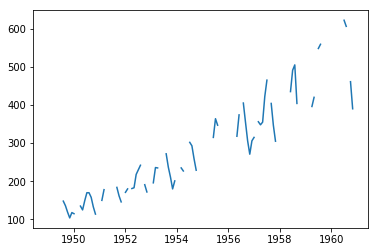

In [5]:
plt.plot(T, X_orig);

In [6]:
def linear_interpolation(data, leftmost, rightmost):
    """
    Given a sequence of scalar data points containing NaN values,
    returns a numpy array where previously NaN values are linearly
    interpolated values between the closest left and right non-NaN
    values.
    
    data : Sequence of data points.
    leftmost : Leftmost value of the data sequence.
    rightmost : Rightmost value of the data sequence.
    """
    X = np.array(data).copy()
    on_nan = False
    begin = 0
    end = len(X)
    for i in range(len(X)):
        if not on_nan and np.isnan(X[i]):
            on_nan = True
            begin = i - 1
        if on_nan and not np.isnan(X[i]):
            end = i
            on_nan = False
            count = end - begin - 1
            b_val = X[begin] if begin >= 0 else leftmost
            e_val = X[end] if end < len(X) - 1 else rightmost
            X[begin + 1:end] = np.linspace(b_val, e_val, num=count)
    if np.isnan(X[-1]):
        X[-1] = rightmost
    return X

In [22]:
M = 4
N = len(X_orig) - 1
# Indices for X when setting G_X at each step
x_indices = np.column_stack(range(M - i, N - i + 1) for i in range(1, M + 1))
# G_A skeleton
G_A = np.zeros((N - M + 1, N + 1))
row_indices = np.arange(0, N - M + 1)
col_indices = np.arange(M, N + 1)
G_A[row_indices, col_indices] = -1
# Indices for G_A when setting G_A at each step
row_indices = np.column_stack(range(N - M + 1) for _ in range(M))
col_indices = x_indices[:, ::-1]
a_indices = (row_indices, col_indices)

In [44]:
missing_vals = np.isnan(X_orig)
min_val = np.min(X_orig[~missing_vals])
max_val = np.max(X_orig[~missing_vals])
X = linear_interpolation(X_orig, min_val, max_val)
#X = X_orig.copy()
#X[missing_vals] = 0
X_ob = X[~missing_vals]  # observed values don't change
for _ in range(1000):
    # find A via least squares (R*x = Q.T*b)
    G_X = X[x_indices]
    X_mn = X[M:]
    Q, R = la.qr(G_X)
    A = la.solve(R, np.dot(Q.T, X_mn))
    # find X via least squares
    G_A[a_indices] = A
    G_A_ob = G_A[:, ~missing_vals]
    G_A_mi = G_A[:, missing_vals]
    Q, R = la.qr(G_A_mi)
    b = np.dot(-G_A_ob, X_ob)
    X_mi = la.solve(R, np.dot(Q.T, b))
    X[missing_vals] = X_mi

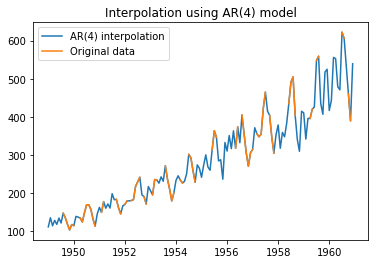

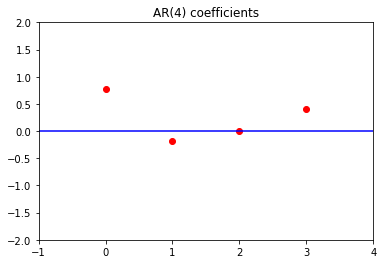

[ 0.78309444 -0.1801911   0.00573094  0.40554038]


In [67]:
plt.plot(T, X, label='AR(4) interpolation')
plt.plot(T, X_orig, label='Original data')
plt.legend()
plt.title('Interpolation using AR(4) model')
plt.show()

plt.plot(A, 'or')
plt.xlim([-1, 4])
plt.ylim([-2, 2])
plt.axhline(0, color='blue')
plt.title('AR(4) coefficients')
plt.show()
print(A)